### Get Information About a Image

In [3]:
from PIL import Image
import numpy as np

def get_image_info(image_path):
    try:
        with Image.open(image_path) as img:
            # Verificar se a imagem está em escala de cinza
            is_grayscale = img.mode == "L"

            # Converter a imagem para um array NumPy para verificar o tipo de dado
            img_array = np.array(img)
            dtype = img_array.dtype

            # Verificar se os valores são inteiros ou floats
            is_integer = np.issubdtype(dtype, np.integer)
            is_float = np.issubdtype(dtype, np.floating)

            return {
                "format": img.format,
                "mode": img.mode,
                "is_grayscale": is_grayscale,
                "dtype": dtype,
                "is_integer": is_integer,
                "is_float": is_float
            }

    except Exception as e:
        print(f"Erro ao abrir a imagem {image_path}: {e}")
        return None

# Exemplo de uso
image_path = '/mnt/ssd/hpa-single-cell-image-classification/train/0a00aab2-bbbb-11e8-b2ba-ac1f6b6435d0_blue.png'
image_info = get_image_info(image_path)

if image_info:
    print(f"Formato da imagem: {image_info['format']}")
    print(f"Modo da imagem: {image_info['mode']}")
    print(f"Imagem em escala de cinza: {image_info['is_grayscale']}")
    print(f"Tipo de dado dos pixels: {image_info['dtype']}")
    print(f"Valores armazenados como inteiros: {image_info['is_integer']}")
    print(f"Valores armazenados como floats: {image_info['is_float']}")
else:
    print("Não foi possível determinar as informações da imagem.")


Formato da imagem: PNG
Modo da imagem: L
Imagem em escala de cinza: True
Tipo de dado dos pixels: uint8
Valores armazenados como inteiros: True
Valores armazenados como floats: False


### Resize Images

In [5]:
import os
from PIL import Image
from tqdm import tqdm  # Biblioteca para mostrar a barra de progresso

# Diretório do dataset
dataset_dir = '/mnt/ssd/hpa-single-cell-image-classification/train'
output_dir = '/mnt/ssd/hpa-single-cell-image-classification/resized_train'

# Função para redimensionar uma imagem grayscale com pouca perda de qualidade
def resize_image(image_path, output_size=(512, 512)):
    try:
        with Image.open(image_path) as img:
            img = img.convert("L")  # Garantir que a imagem esteja em grayscale
            img = img.resize(output_size, Image.LANCZOS)  # LANCZOS é um bom algoritmo para alta qualidade
            return img
    except Exception as e:
        print(f"Erro ao processar a imagem {image_path}: {e}")
        return None

# Criar diretório de saída se não existir
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Contar o número total de arquivos para a barra de progresso
total_files = sum([len(files) for _, _, files in os.walk(dataset_dir)])

# Loop através de todas as imagens no diretório com a barra de progresso
for subdir, _, files in tqdm(os.walk(dataset_dir), total=total_files, desc="Redimensionando imagens"):
    for file in files:
        image_path = os.path.join(subdir, file)
        resized_image = resize_image(image_path)

        if resized_image:
            # Definir o caminho de saída mantendo a estrutura do diretório
            relative_path = os.path.relpath(image_path, dataset_dir)
            output_path = os.path.join(output_dir, relative_path)
            output_subdir = os.path.dirname(output_path)

            if not os.path.exists(output_subdir):
                os.makedirs(output_subdir)

            # Salvar a imagem redimensionada
            resized_image.save(output_path)

print("Redimensionamento completo!")


Redimensionando imagens:   0%|          | 1/87224 [1:30:13<131169:13:05, 5413.81s/it]

Redimensionamento completo!


### Join Channels to One Image

In [24]:
# Importar bibliotecas
import os
import cv2
import numpy as np
from tqdm import tqdm

# Diretório do dataset
dataset_dir = '/mnt/ssd/hpa-single-cell-image-classification/resized_train'
output_dir = '/mnt/ssd/hpa-single-cell-image-classification/join_resized_train'

# Listar todos os arquivos no diretório
filenames = os.listdir(dataset_dir)

# Extrair a parte do nome do arquivo antes do primeiro "_"
filenames = [filename.split("_")[0] for filename in filenames]

# Remover duplicatas
filenames = list(set(filenames))

# Criar diretório de saída se não existir
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Barra de progresso
for filename in tqdm(filenames, desc="Concatenando imagens"):
    # Pegar todas as imagens
    colors = ["_blue", "_red", "_yellow", "_green"]
    images = [cv2.imread(os.path.join(dataset_dir, filename + color + ".png"), cv2.IMREAD_GRAYSCALE) for color in colors]
    
    # Verificar se todas as imagens foram carregadas corretamente
    if len(images) != 4 or any([image is None for image in images]):
        print(f"Erro ao carregar as imagens para {filename}")
        break

    # Concatenar as imagens ao longo do eixo de profundidade (criando 4 canais)
    image = np.stack(images, axis=-1)

    # Salvar a imagem concatenada
    output_path = os.path.join(output_dir, filename + ".png")
    cv2.imwrite(output_path, image)


Concatenando imagens: 100%|██████████| 21806/21806 [07:21<00:00, 49.42it/s]


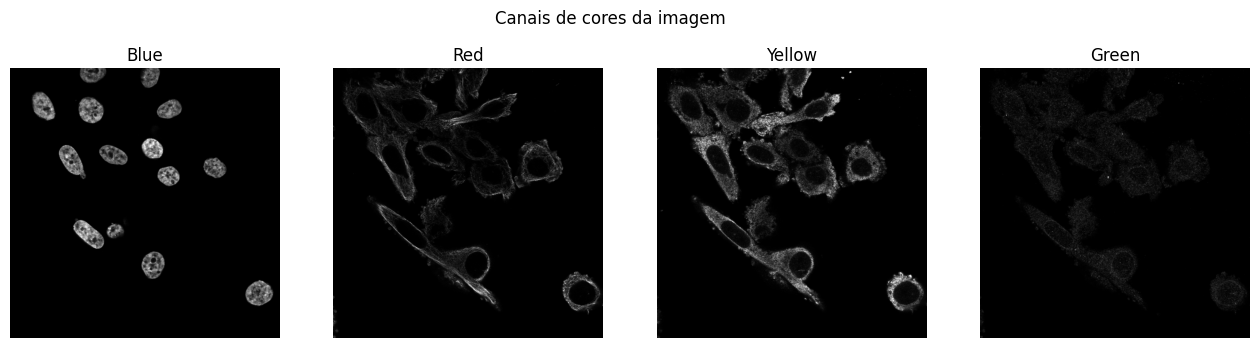

In [25]:
# Pegar uma imagem de exemplo e mostrar
dataset_dir = '/mnt/ssd/hpa-single-cell-image-classification/join_resized_train'
example_image = "0a00aab2-bbbb-11e8-b2ba-ac1f6b6435d0.png"
example_path = os.path.join(dataset_dir, example_image)

# Carregar a imagem
image = cv2.imread(example_path, cv2.IMREAD_UNCHANGED)

# Mostrar a imagem com cada canal em uma cor [blue, red, yellow, green]
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    axes[i].imshow(image[..., i], cmap="gray")
    axes[i].set_title(["Blue", "Red", "Yellow", "Green"][i])
    axes[i].axis("off")

plt.suptitle("Canais de cores da imagem")
plt.show()